# Neural networks

###### COMP4670/8600 - Statistical Machine Learning - Tutorial



Setting up the environment

In this lab, we will train a neural network as a classifer.

## Textbook Questions
These questions are hand picked to both be of reasonable difficulty and demonstrate what you are expected to be able to solve. The questions are labelled in Bishop as either $\star$, $\star\star$, or $\star\star\star$ to rate its difficulty.

- **Question 5.1**: First derive the relationship between $\tanh(\alpha)$ and $\sigma(\alpha)$, then use Eq. 5.4 in Bishop to compare those two neural networks. The key point is having a clear definition of the notations you will use.

- **Question 5.2**: Please figure out which parts of Gaussian distribution have parameters when taking the logarithm.

- **Question 5.6**: Students should always know where the activation comes from and express the derivative of logistic sigmoid function in terms of the sigmoid function itself.

- **Question 5.15**: Use the symmetry between backpropagation and forward propagation.

- **Question 5.25**: Challenging but important question. Show you in which case gradient descent really work. First represent the current weight with its previous value and then use mathematical induction to prove Eq. 5.197.

- **Question 5.27**: Follow what Section 5.5.5 did.

- **Question 5.29**: Students should understand how to take the derivative of Gaussian distribution.

- **Question 5.40**: Maping binary classfication domain to multiclass domain is a very practical demand.

### Assumed knowledge
- Neural networks (lectures)
- Classifiers (lab)

### After this lab, you should be comfortable with:
- Implementing a neural network and a simple optimizer
- Calculating back-propogation formulas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
%matplotlib inline

## Load the data

We will be working with a similar dataset to the one used in the Classification lab.
This is a census-income dataset, which shows income levels for people in the 1994 US Census. We will predict whether a person has $\leq \$50000$ or $> \$50000$ income per year.

Unlike in the Classification lab, this data is not linearly separable. That is, the linear classification techniques you learnt about in previous weeks are not effective on this data.

The data is included with this notebook as `05-dataset.tsv`. Load the data into a NumPy array called `data` using numpy genfromtxt function.
The column names are given in the variable `columns` below.

In [2]:
columns = ['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']

In [3]:
data = np.genfromtxt("05-dataset.tsv")
data.shape

(32561, 8)

In this tutorial we will implement a neural network using only numpy functions.

## Building blocks for a neural network

Neural network libraries like PyTorch and TensorFlow seal different functionalities into different classes.

First, implement the fully connected layer which does $\mathbf{y} = X\mathbf{w} + \mathbf{b}$.
It is also called Linear layer in PyTorch or Dense layer in TensorFlow.

In [4]:
# Solution

class FullyConnectedLayer():
    """
    This is a class skeleton provided.
    It should perform y = Xw + b and its correspongding gradient.
    If you never defined any classes in python before, you probably want to read other tutorials.
    """
    def __init__(self, in_features, out_features):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        What each represents will be explained in the next few functions.
        """
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.zeros((in_features, out_features))
        self.bias = np.zeros((out_features, 1))
        self.g_weight = np.zeros((in_features, out_features))
        self.g_bias = np.zeros((out_features, 1))
        self.input = None

    def init_weights(self):
        """
        Currently, the weight and bias of this layer is initilized to zero, which is terrible.
        You want to re-initilize the weight with standard normal distribution 
        and the bias with uniform distribution defined on range 0 to 1.
        Or you can try different initilization methods.
        After you finish, comment out raise NotImplementedError.
        No return value is needed.
        """
        
        self.weight = np.random.randn(self.in_features, self.out_features)
        self.bias = np.random.rand(self.out_features, 1)

    def forward_pass(self, X):
        """
        Take the output of last layer as X and return the result.
        Don't forget to save the input X to self.input. You will need the input for gradient calculation.
        After you finish, comment out raise NotImplementedError.
        If you are new to python/numpy, you probably want to figure out what is broadcasting 
        (see http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting).
        """

        
        self.input = X
        
        out = np.dot(X, self.weight) + self.bias.T
      
        return out
        

    def backward_pass(self, g_next_layer):
        """
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        You need to calculate 3 things.
        First, the gradient with respect to bias, self.g_bias.
        Second, the gradient with respect to weights, self.g_weight.
        Third, the gradient with respect to last layer (the layer formed by the current weight and bias), g_last_layer.
        Save the gradient with respect to bias and the gradient with respect to weight.
        Return the gradient with respect to last layer.
        """

        self.g_weight = np.dot(self.input.T, g_next_layer)
        self.g_bias = np.sum(g_next_layer, axis=0, keepdims=True)

        g_last_layer = np.dot(g_next_layer, self.weight.T)

        return g_last_layer

    def update(self, learning_rate):
        """
        Update the weight and bias use the gradient that you just calculated.
        No return is needed.
        """
        
        self.weight -= learning_rate*self.g_weight
        self.bias -= learning_rate*self.g_bias.T


### Question 1:

Why is initialising weights and biases to zero terrible?

### Solution

Intialising every value in the weights and biases to the same value is terrible, as then the gradient update is the same for all of them, so the weights and biases will remain a uniform value.

Now let's implement sigmoid function and sigmoid layer.

In [5]:
# Solution

def sigmoid(X):
    """
    Make sure that you function works with X being matrix.
    Use functions in numpy instead of functions in math.
    """
    return 1/(1 + np.exp(-X))

In [6]:
# Solution

class Sigmoid():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None
        self.ctx = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        
        self.input = X
        self.ctx = sigmoid(X)

        return self.ctx

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        g_last_layer = self.ctx * (1 - self.ctx) * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

### Question 2:

Why do we need the activation function to be non-linear?

### Solution
Writing out the math operation executed by two consecutive fully connected layers with the identity transformation we get that:

$$(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b_2} = \mathbf{x}\mathbf{W}_1\mathbf{W}_2 + \mathbf{b}_1\mathbf{W}_2 + \mathbf{b}_2$$

Denote $\mathbf{W}_3 = \mathbf{W}_1\mathbf{W}_2$ and $\mathbf{b}_3 = \mathbf{b}_1\mathbf{W}_2 + \mathbf{b}_2$

Then we get 

$$(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2 = \mathbf{x}\mathbf{W}_3 + \mathbf{b}_3$$

so our two layer network is actually equivalent to some other network with only one fully connected layer.

Likewise if the activation function is a general linear transformation, we could represent it as another matrix $\mathbf{W}_4$ which we could factor into $\mathbf{W}_2$ and get the same result.

However we could not have factorised our two layer network into an equivalent one layer network if there was a non-linear activation function.

Now let's implement binary cross entropy loss and yes, this is the same loss that you used in logistic regression.
Binary cross entropy loss can only deal with two classes. For more than two classes you need softmax function and cross entropy, but let's not worry about that.

In [7]:
# Solution

class BinaryCrossEntropyLoss():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input_y = None
        self.input_t = None
        self.input_N = None


    def forward_pass(self, y, t):
        """
        y: batch_size * 1  0 <= y <= 1, the predictions
        t: batch_size * 1 , the targets
        (make sure y and t have the same shape. (N,) and (N,1) are different!)
        
        Save the input y, t and batch size N and calculate the loss.
        Return the mean of the loss (a scalar).
        """
        
        if len(t.shape) == 1:
            t = t[:, None]

        self.input_y = y
        self.input_t = t
        self.input_N = X.shape[0]

        loss = -(t*np.log(y) + (1-t)*np.log(1 - y))

        return np.mean(loss)
    
    def backward_pass(self, g_next_layer = 1):
        """
        Nomrally, loss layer is the last layer in a neural network. Thus, we set the g_next_layer to 1.
        Calculate the loss of the input y.
        """
        g_last_layer = - (self.input_t/self.input_y - (1 - self.input_t)/(1 - self.input_y))/self.input_N * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass
    

Let's implement a neural network with one hidden layer to solve this classification problem. 

### Question 3
How many input units would there be? How many output units?

### Solution

7 input units, 1 output unit.

## Put them together

Put the bulding block together to form a neural network.

In [8]:
# Solution

class Network():
    def __init__(self):
        """
        Since our simple nerual network acts sequentially, 
        we can put all layers in a list for convenient traversal
        Initialize all layers that you need (two fully connected layers, two sigmoid layers).
        Append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers. Choose a sensible hidden layer size.
        """
        self.sequential = []
        
        fc1 = FullyConnectedLayer(7, 16)
        fc1.init_weights()
        self.sequential.append(fc1)

        sigmoid1 = Sigmoid()
        self.sequential.append(sigmoid1)

        fc2 = FullyConnectedLayer(16, 1)
        fc2.init_weights()
        self.sequential.append(fc2)

        sigmoid2 = Sigmoid()
        self.sequential.append(sigmoid2)
        
        
    def forward_pass(self, X):

        for l in self.sequential:

            X = l.forward_pass(X)

        return X

    def backward_pass(self, grad):
        
        for l in reversed(self.sequential):

            grad = l.backward_pass(grad)
            

    def update(self, learning_rate):

        for l in self.sequential:

            l.update(learning_rate)

In [9]:
np.random.seed(1)
net = Network()
bce = BinaryCrossEntropyLoss()

You have already set up a neural network.
In the backward_pass function of each layer, you calculated the gradient of the input and the gradient of the weight.
Now, get a pen and a paper and try to replace g_next_layer with the backward_pass function of the next layer, all the way back to binary cross entropy loss. Don't change any code, just write it down.

Compare the results with the text book.
I hope you can see how this layer structure naturally implements the chain rule. 

## Training the neural network

Split your data in half randomly, into a test set and a training set. Train the neural network on your training set. You may want to google train_test_split and accuracy_score of sklearn.
If you get any memory error, make sure that all vectors in you calculate have shape (D, 1). (D, 1) and (D,) are different.
Don't forget to normalize each feature to get mean 0 and variance 1.

In [10]:
""" Generate train and testing set """

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
data = np.genfromtxt("05-dataset.tsv")

y = data[:, 0]
X = data[:, 1:]

X_mean = X.mean(axis = 0)

X -= X_mean
X /= np.var(X, axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

training_epoch = 1000

train_acc_list = np.zeros(training_epoch)
train_loss_list = np.zeros(training_epoch)
test_acc_list = np.zeros(training_epoch)
test_loss_list = np.zeros(training_epoch)

training_epoch = 1000

train_acc_list = np.zeros(training_epoch)
train_loss_list = np.zeros(training_epoch)
test_acc_list = np.zeros(training_epoch)
test_loss_list = np.zeros(training_epoch)

In [11]:
for i in range(training_epoch):
    """
    This is the main training loop.
    You need to first run a forward pass, get the predicted probability, 
    put it into the loss function, calculate the loss and do a back pass.
    Then update the network.
    Calculate the test loss and the current accuracy on both the train and test sets.
    Save these to a list for plotting later.
    Experiment to find a good learning rate.
    """

    p = net.forward_pass(X_train)
    
    predict = (p > 0.5)

    train_acc = accuracy_score(y_train, predict)
    
    train_loss = bce.forward_pass(p, y_train)
    
    train_acc_list[i] = train_acc
    train_loss_list[i] = train_loss

    grad = bce.backward_pass()
    
    net.backward_pass(grad)
    
    net.update(0.1)
    
    p = net.forward_pass(X_test)
    
    predict = (p > 0.5)

    test_acc = accuracy_score(y_test, predict)
    test_loss = bce.forward_pass(p, y_test)
    
    test_acc_list[i] = test_acc
    test_loss_list[i] = test_loss

    print("iteration %d: train_acc %f, train_loss %f, test_acc %f, test_loss %f" %(i+1, train_acc, train_loss, test_acc, test_loss))

iteration 1: train_acc 0.259705, train_loss 0.824344, test_acc 0.514649, test_loss 0.789516
iteration 2: train_acc 0.512162, train_loss 0.790993, test_acc 0.655427, test_loss 0.760039
iteration 3: train_acc 0.652826, train_loss 0.762136, test_acc 0.659849, test_loss 0.734452
iteration 4: train_acc 0.651044, train_loss 0.737104, test_acc 0.652540, test_loss 0.712171
iteration 5: train_acc 0.642568, train_loss 0.715318, test_acc 0.650144, test_loss 0.692695
iteration 6: train_acc 0.639988, train_loss 0.696286, test_acc 0.650021, test_loss 0.675601
iteration 7: train_acc 0.639803, train_loss 0.679592, test_acc 0.650021, test_loss 0.660532
iteration 8: train_acc 0.639926, train_loss 0.664882, test_acc 0.650021, test_loss 0.647187
iteration 9: train_acc 0.639926, train_loss 0.651861, test_acc 0.650021, test_loss 0.635314
iteration 10: train_acc 0.639865, train_loss 0.640280, test_acc 0.649960, test_loss 0.624701
iteration 11: train_acc 0.640049, train_loss 0.629932, test_acc 0.649960, test_

Plots of training accuracy curve against testing accuracy curve, and training loss curve against testing loss curve.

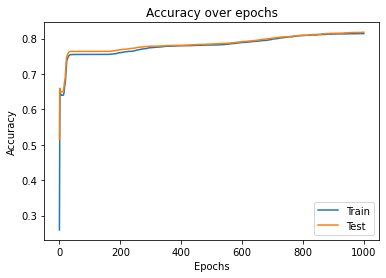

In [12]:
plt.title("Accuracy over epochs")
plt.plot(train_acc_list, label="Train")
plt.plot(test_acc_list, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

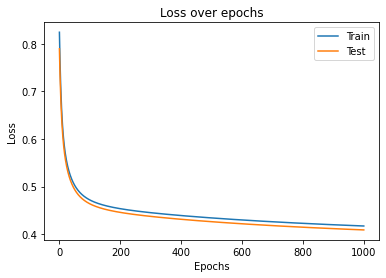

In [13]:
plt.title("Loss over epochs")
plt.plot(train_loss_list, label="Train")
plt.plot(test_loss_list, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Here is an super cool website:https://playground.tensorflow.org/.
Have fun in there.